# How should the orbital phase of BAM and GaTech Runs be aligned?

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
# Import useful things
from nrutils import rgb,alert,green
from nrutils import scsearch,gwylm,FinalSpin0815,EradRational0815
# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#
from numpy import *
from numpy.linalg import pinv
#
from scipy.optimize import minimize

## Find GT and BAM Simluations of Interest (like parameters)

In [2]:
B = scsearch(institute='bam',verbose=True,nonspinning=True,q=4)
G = scsearch(institute='gt',verbose=True,nonspinning=True,q=4)

[scsearch]>> Found institute (='bam') keyword.
[scsearch]>> Found nonspinning (=True) keyword.
[scsearch]>> Found q (=4) keyword.
[scsearch]>> Found validate_remnant (=False) keyword.
[scsearch]>> Found verbose (=True) keyword.
## Found 2 possibly degenerate simulations:
[0001][silures] BAM: ns-q4.00	(q4a0_T_112_448)
[0002][silures] BAM: ns-q4.00	(um4_88)

[scsearch]>> Found institute (='gt') keyword.
[scsearch]>> Found nonspinning (=True) keyword.
[scsearch]>> Found q (=4) keyword.
[scsearch]>> Found validate_remnant (=False) keyword.
[scsearch]>> Found verbose (=True) keyword.
## Found 8 possibly degenerate simulations:
[0001][bradwr] HRq-series: ns-q4.00	(D9_q4.0_a0.0_m160)
[0002][bradwr] HR-series: ns-q4.00	(D10_q4.00_a0.0_0.0_m240)
[0003][bradwr] HR-series: ns-q4.00	(D11_q4.00_a0.0_m200)
[0004][bradwr] HR-series: ns-q4.00	(D11_q4.00_a0.0_m180)
[0005][bradwr] HR-series: ns-q4.00	(D11_q4.00_a0.0_m160)
[0006][bradwr] HR-series: ns-q4.00	(D09_q4.00_a0.0_m160)
[0007][bradwr] HR-series:

## Load the waveform data

In [5]:
s = [0,1]; y = []
s[0],s[1] = B[0],G[2]
lm = [(2,2),(2,1),(3,3),(4,4),(4,3),(3,2)]
for k in s:
    # NOTE that we use a common dt here
    x = gwylm(k,lm=lm,verbose=False,dt=0.4)
    y.append( x )

(gwylm)>> Found dt (=0.4) keyword.
(gwylm)>> Found lm (=[(2, 2), (2, 1), (3, 3), (4, 4), (4, 3), (3, 2)]) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x10ab41200>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(gwylm)>> The (extraction_parameter,level) is (5,6), which differs from the config values of (5,5). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2), (2, 1), (3, 3), (4, 4), (4, 3), (3, 2)]
(load)>> Loading: psi3col.r5.l6.l2.m2.gz
(straighten_wfarr)>> Repeated time values were found in the array. Offending rows will be removed.
(gwylm.setfields)>> Interpolating data to dt=0.400000
(straighten_wfarr)>> Repeated time values were found in the array. Offending rows will be removed.
(gwylm.setfields)>> Interpolating data to dt=0.400000
(load)>> Loading: psi3col.r5.l6.l2.m1.gz
(strai

## Align waveform peaks

In [19]:
this_,yref_ = y
this_.tpeakalign(yref_,apply=True)

## Plot the $l=m=2$ modes to verify peak alignment

([<matplotlib.axes._subplots.AxesSubplot at 0x10c8597d0>,
 <matplotlib.figure.Figure at 0x10c859090>)

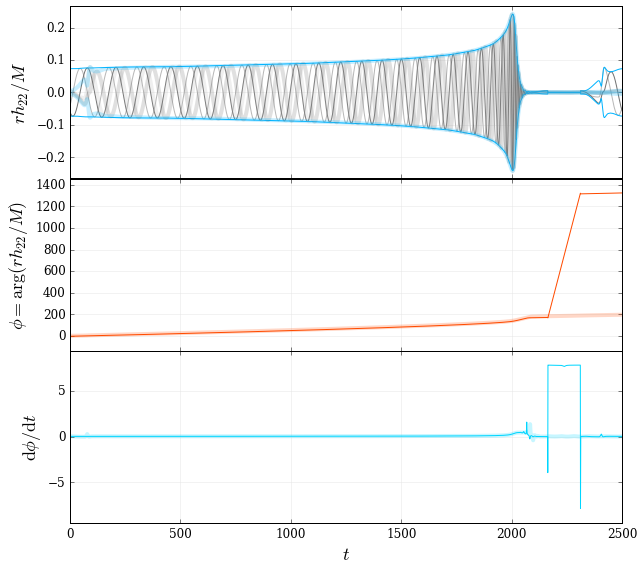

In [20]:
this_.lm[2,2]['strain'].plot( ref_gwf=yref_.lm[2,2]['strain'] )

## Do the same for ringdown only, note that the phases are still not aligned

(ringdown)>> Time will be listed relative to the peak of strain.
(ringdown)>> Time will be listed relative to the peak of strain.


([<matplotlib.axes._subplots.AxesSubplot at 0x10acc4850>,
 <matplotlib.figure.Figure at 0x109f74550>)

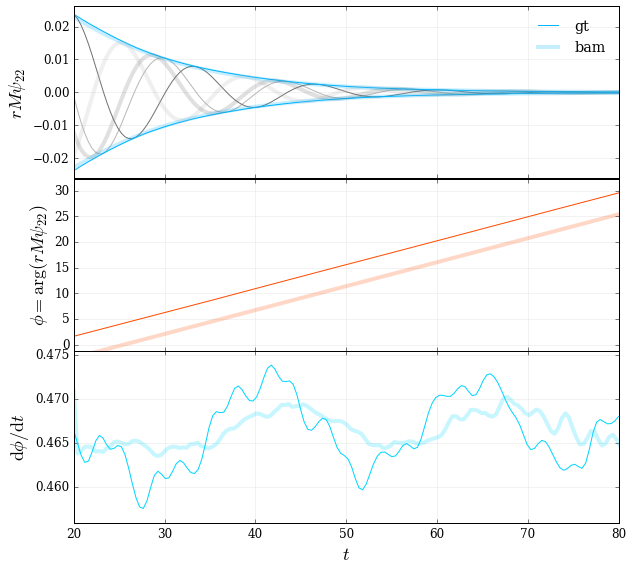

In [23]:
aa = this_.ringdown(T0=20)
bb = yref_.ringdown(T0=20)
bb.lm[2,2]['psi4'].plot( ref_gwf=aa.lm[2,2]['psi4'],labels=('gt','bam') )

## Compute a sky-averaged NR match, and then align and plot modes from the simulations

(ringdown)>> Time will be listed relative to the peak of strain.
(ringdown)>> Time will be listed relative to the peak of strain.
(rotate!)>> Note that this method only affects waveforms, meaning that rotations are not back propagated to metadata: spins, component positions etc. This is for future work. Call rotate with verbose=False to disable this message.
(rotate!)>> Note that this method only affects waveforms, meaning that rotations are not back propagated to metadata: spins, component positions etc. This is for future work. Call rotate with verbose=False to disable this message.
(rotate!)>> Note that this method only affects waveforms, meaning that rotations are not back propagated to metadata: spins, component positions etc. This is for future work. Call rotate with verbose=False to disable this message.
(rotate!)>> Note that this method only affects waveforms, meaning that rotations are not back propagated to metadata: spins, component positions etc. This is for future work. Ca

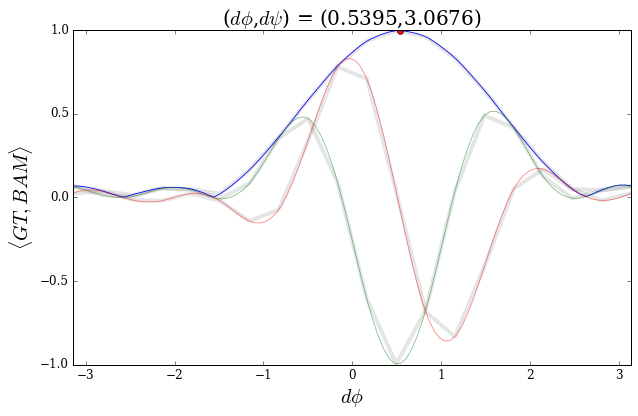

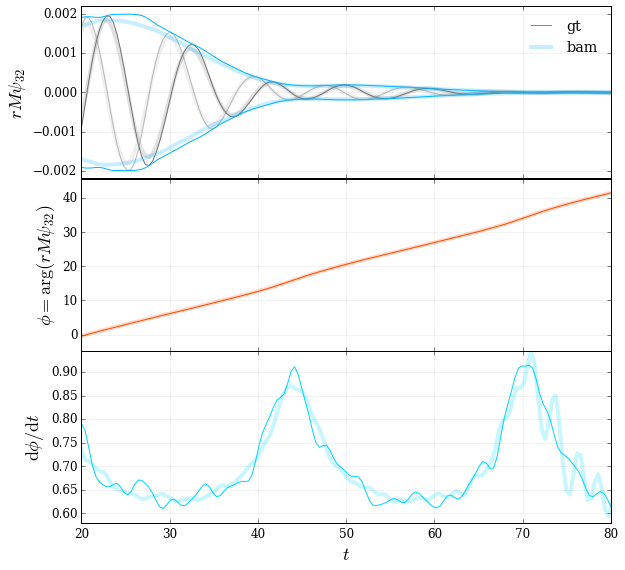

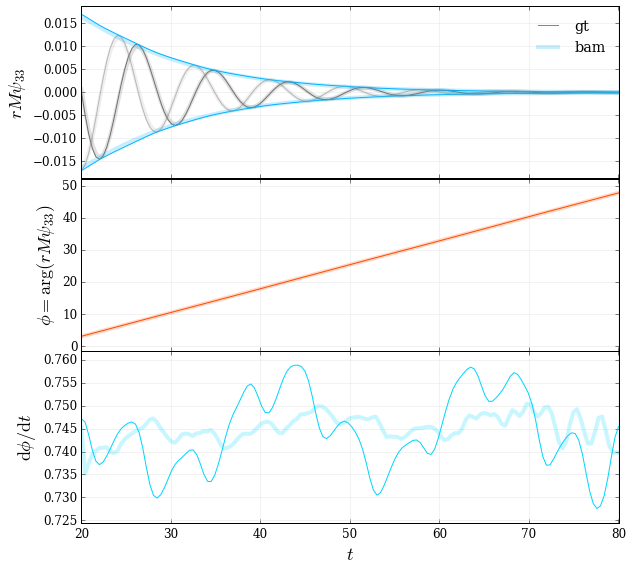

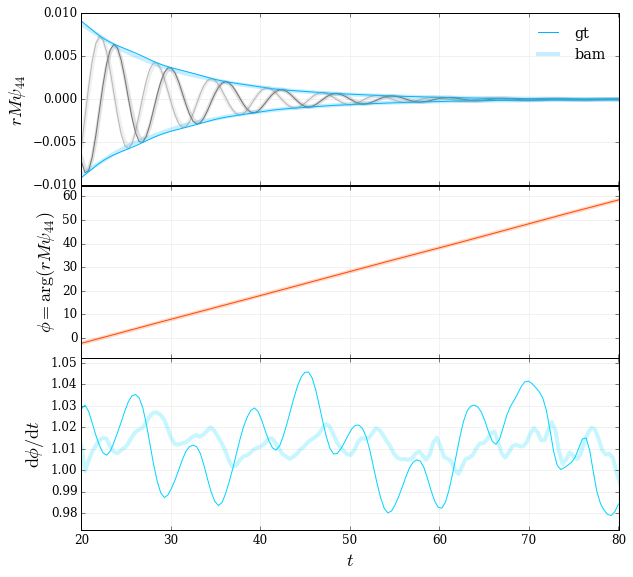

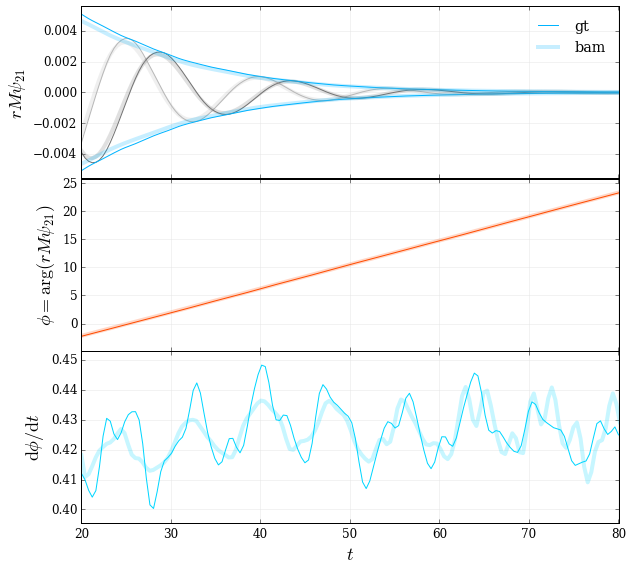

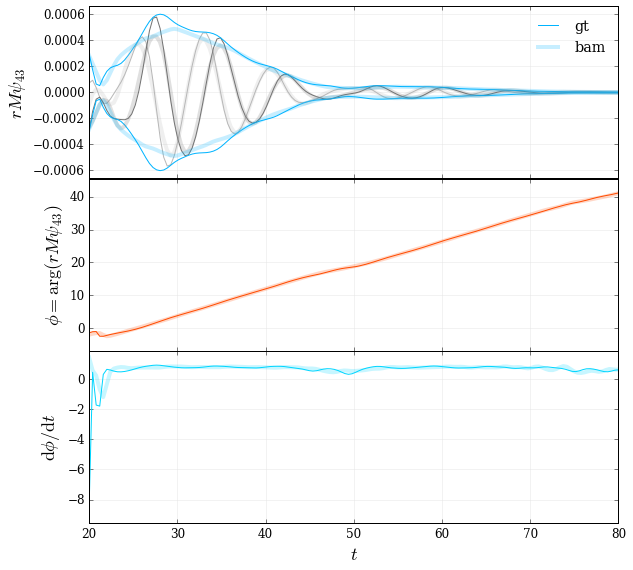

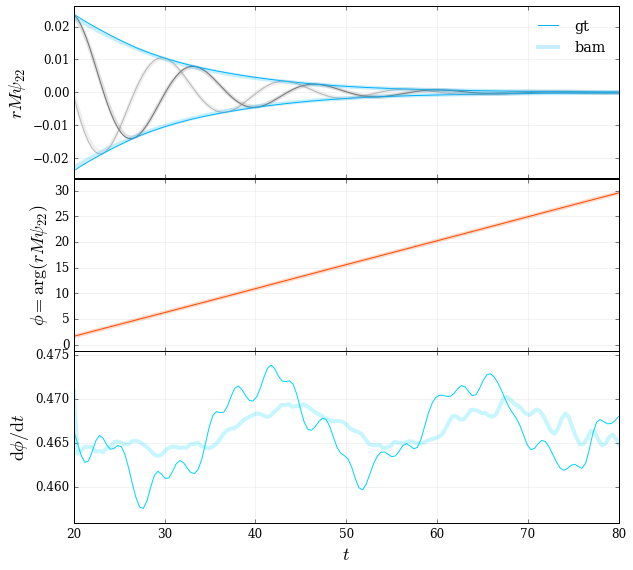

In [24]:

m = []
dphi_range = pi*linspace(-1,1,20)
dphis = pi*linspace(-1,1,1e2).T

from scipy.interpolate import interp1d as spline
from kerr import lim

aa = this_.ringdown(T0=20)
bb = yref_.ringdown(T0=20)


for dphi in dphi_range:
    m.append( aa.nrmatch(bb,dphi) )
    
m = array(m)

M = lambda dphi_: spline(dphi_range,m.real, kind='cubic')(dphi_) + 1j*spline(dphi_range,m.imag, kind='cubic')(dphi_)
ms = M(dphis)

k_opt = argmax(abs(ms))
dphi_opt = dphis[k_opt]
dpsi_opt = -angle(M(dphi_opt))

close('all')
fig = figure( figsize=2*array([5,3]) )

plot( dphi_range, abs(m), linewidth=4, color='k',alpha=0.1 )
plot( dphi_range, m.real, linewidth=4, color='k',alpha=0.1 )
plot( dphi_range, m.imag, linewidth=4, color='k',alpha=0.1 )

plot( dphis, abs(ms) )
plot( dphis, ms.real, alpha=0.5 )
plot( dphis, ms.imag, alpha=0.5 )
plot( dphi_opt, abs(M(dphi_opt)), 'or' )

title(r'($d\phi$,$d\psi$) = (%1.4f,%1.4f)'%(  dphi_opt,dpsi_opt  ) )
xlabel(r'$d\phi$')
ylabel(r'$\langle GT,BAM \rangle$')

xlim(lim(dphis))

# 
for j in this_.lm:
    bb.lm[j]['psi4'].plot( ref_gwf = aa.rotate( dphi_range[argmax(abs(m))], apply=False, dpsi=-angle(m[argmax(abs(m))]) ).lm[j]['psi4'],labels=('gt','bam') )

## Use the nrutils implementation to do the same thing

(ringdown)>> Time will be listed relative to the peak of strain.
(ringdown)>> Time will be listed relative to the peak of strain.
(align)>> Performing sky-ageraged match (no noise curve) to estimate optimal shift in orbital phase.
(align)>> Obtaining numerical estimate of optimal shift in orbital phase.
(rotate!)>> Note that this method only affects waveforms, meaning that rotations are not back propagated to metadata: spins, component positions etc. This is for future work. Call rotate with verbose=False to disable this message.
(align)>> (dphi_opt,dpsi_opt) = (-0.5413,-3.0623)


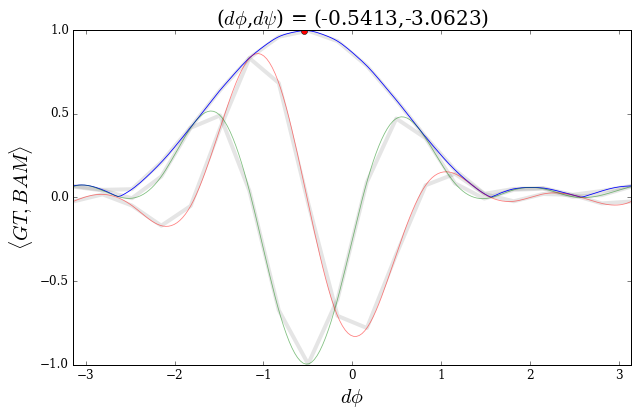

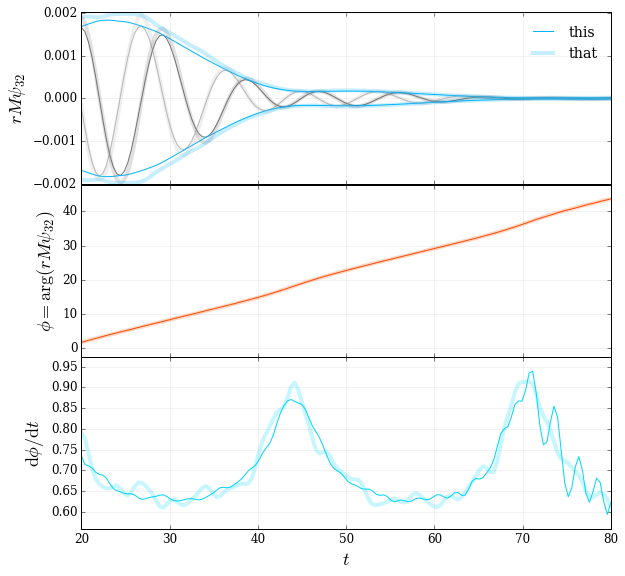

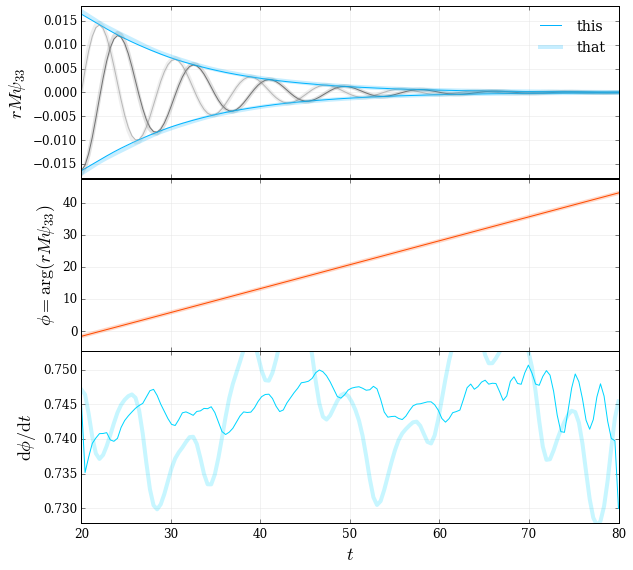

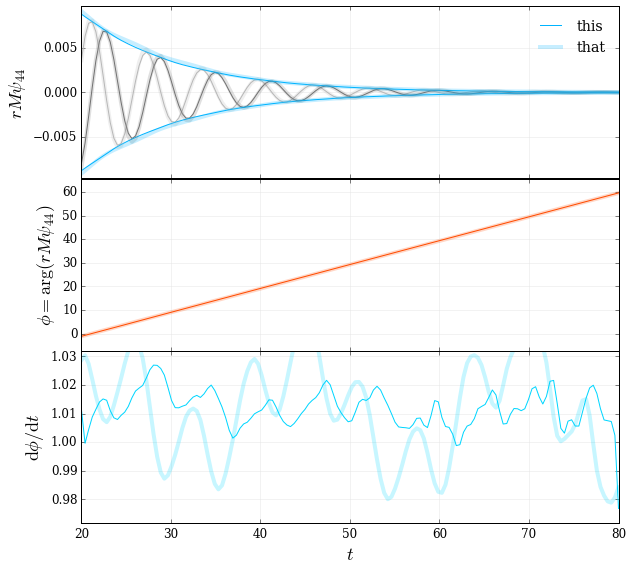

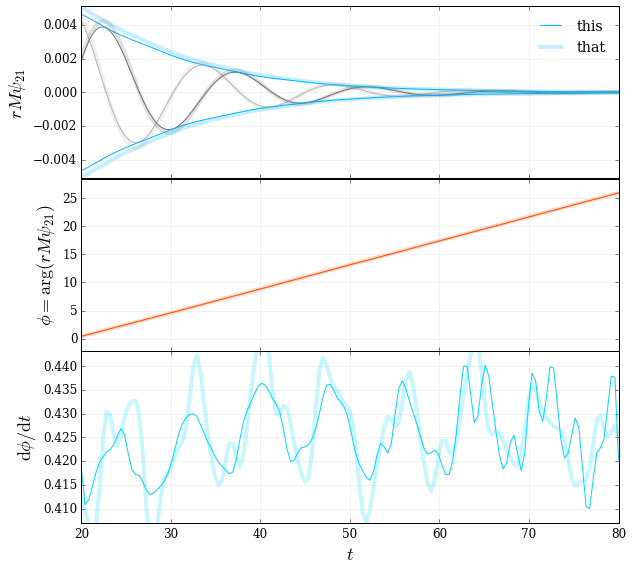

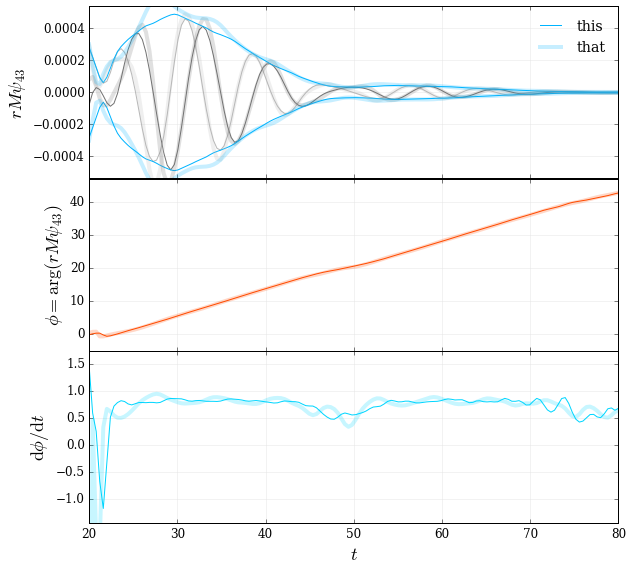

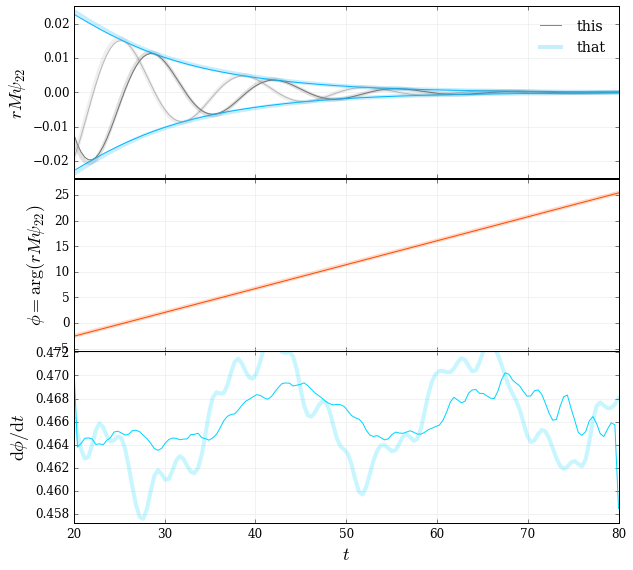

In [41]:
bb = this_.ringdown(T0=20,T1=80)
aa = yref_.ringdown(T0=20,T1=80)
aa.align(bb,verbose=True,plot=True)